In [ ]:
!git clone https://github.com/zhn66776/Tidal_try.git

Cloning into 'Tidal_try'...
remote: Enumerating objects: 610, done.
remote: Counting objects: 100% (255/255), done.
remote: Compressing objects: 100% (137/137), done.
remote: Total 610 (delta 137), reused 218 (delta 118), pack-reused 355 (from 1)
Receiving objects: 100% (610/610), 71.26 MiB | 15.92 MiB/s, done.
Resolving deltas: 100% (268/268), done.


In [ ]:
cd Tidal_try

/content/Tidal_try


Selected start index: 62739
Epoch 1/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - loss: 0.1016 - val_loss: 0.0361 - learning_rate: 0.0010
Epoch 2/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0328 - val_loss: 0.0223 - learning_rate: 0.0010
Epoch 3/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0214 - val_loss: 0.0163 - learning_rate: 0.0010
Epoch 4/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0163 - val_loss: 0.0133 - learning_rate: 0.0010
Epoch 5/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0134 - val_loss: 0.0117 - learning_rate: 0.0010
Epoch 6/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0117 - val_loss: 0.0102 - learning_rate: 0.0010
Epoch 7/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0103 - val_loss: 0.0090 - learning_rate: 0.0010
Epoch 8/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0093 - val_loss: 0.0082 - learning_rate: 0.0010
Epoch 9/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0084 - val_loss: 0.0075 - learning_rate

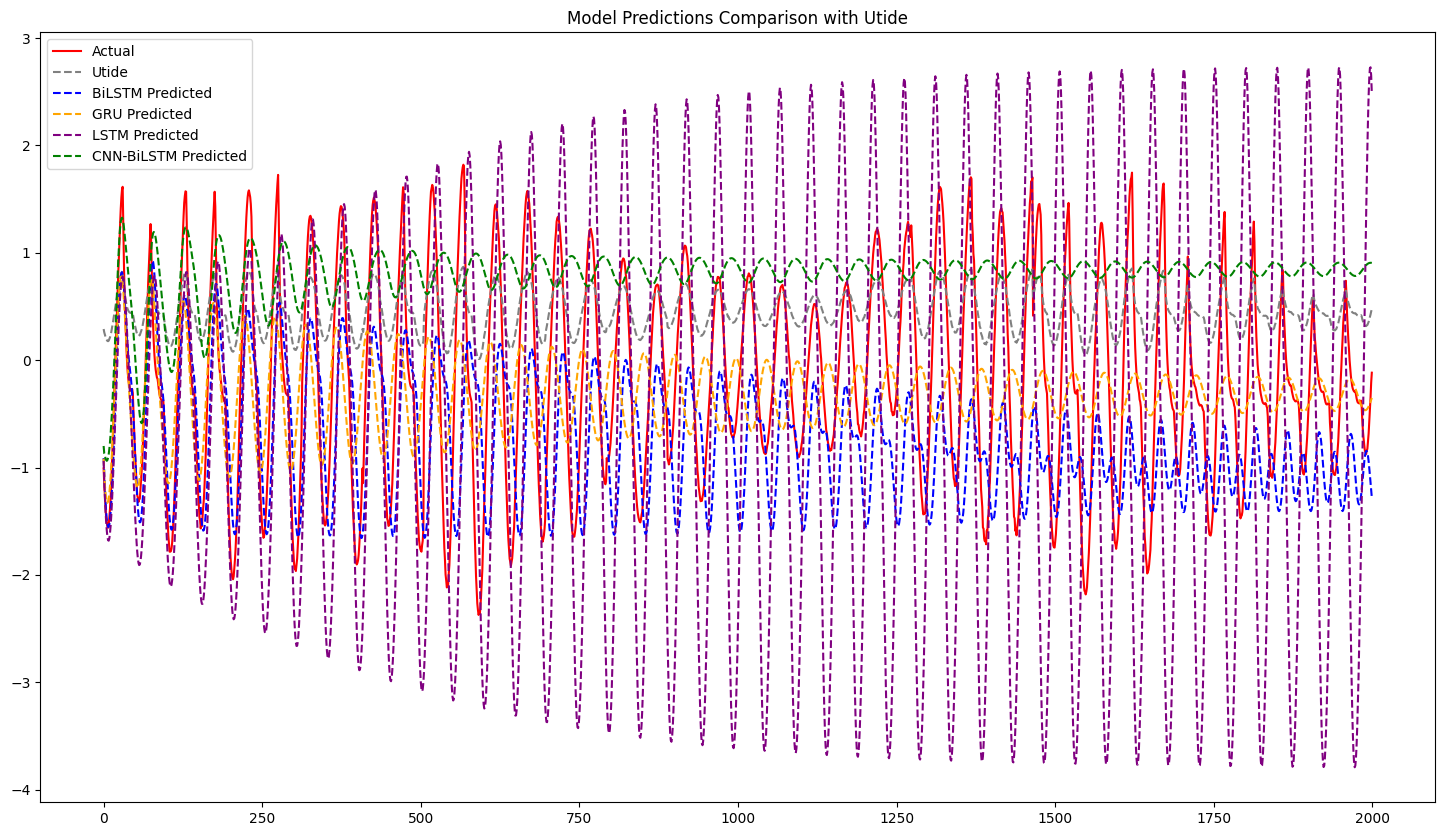

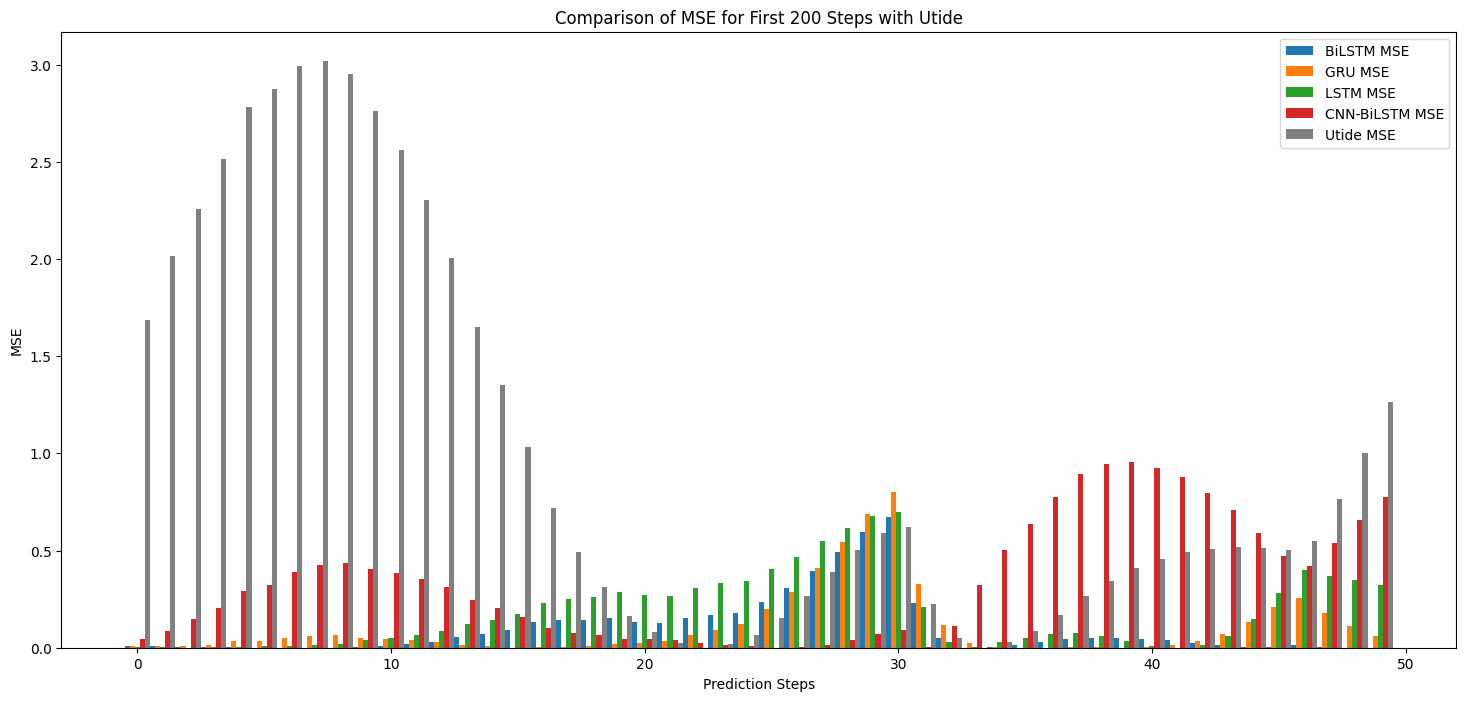

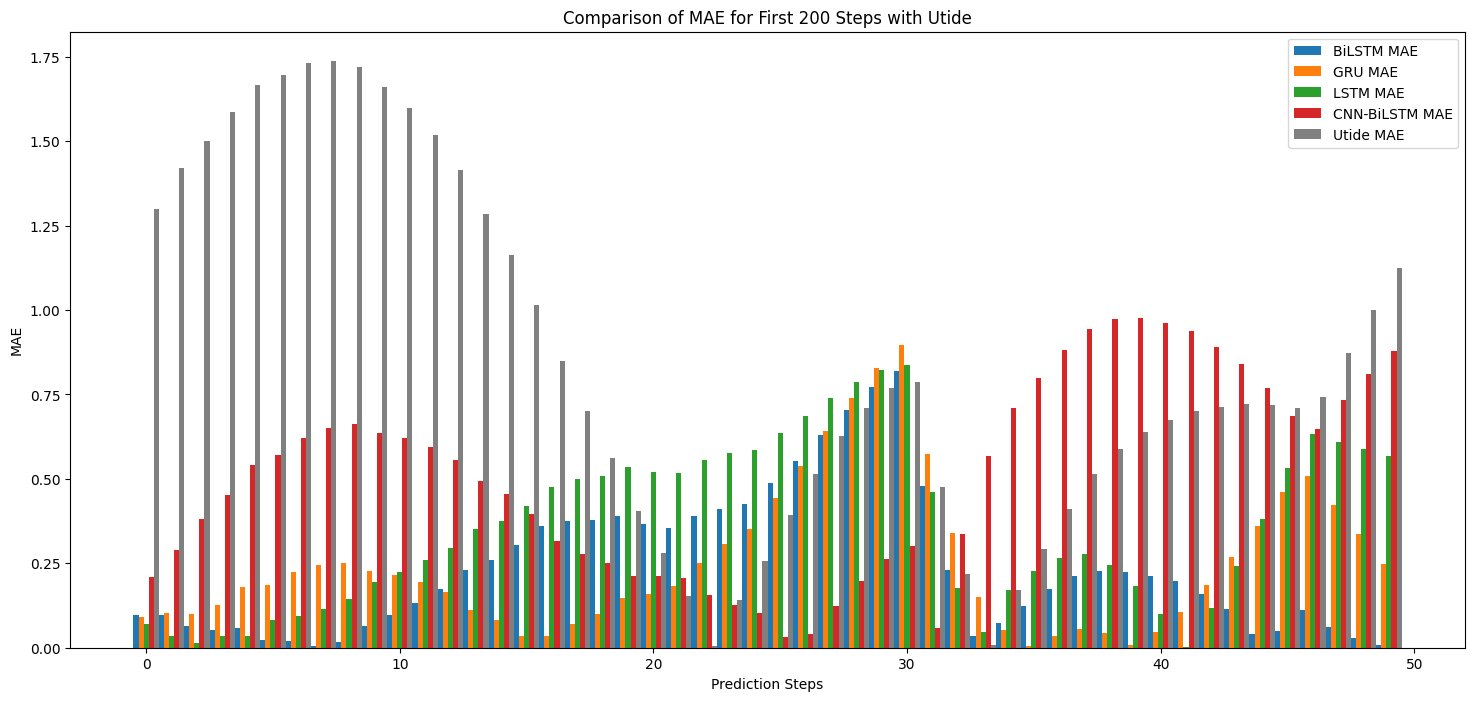

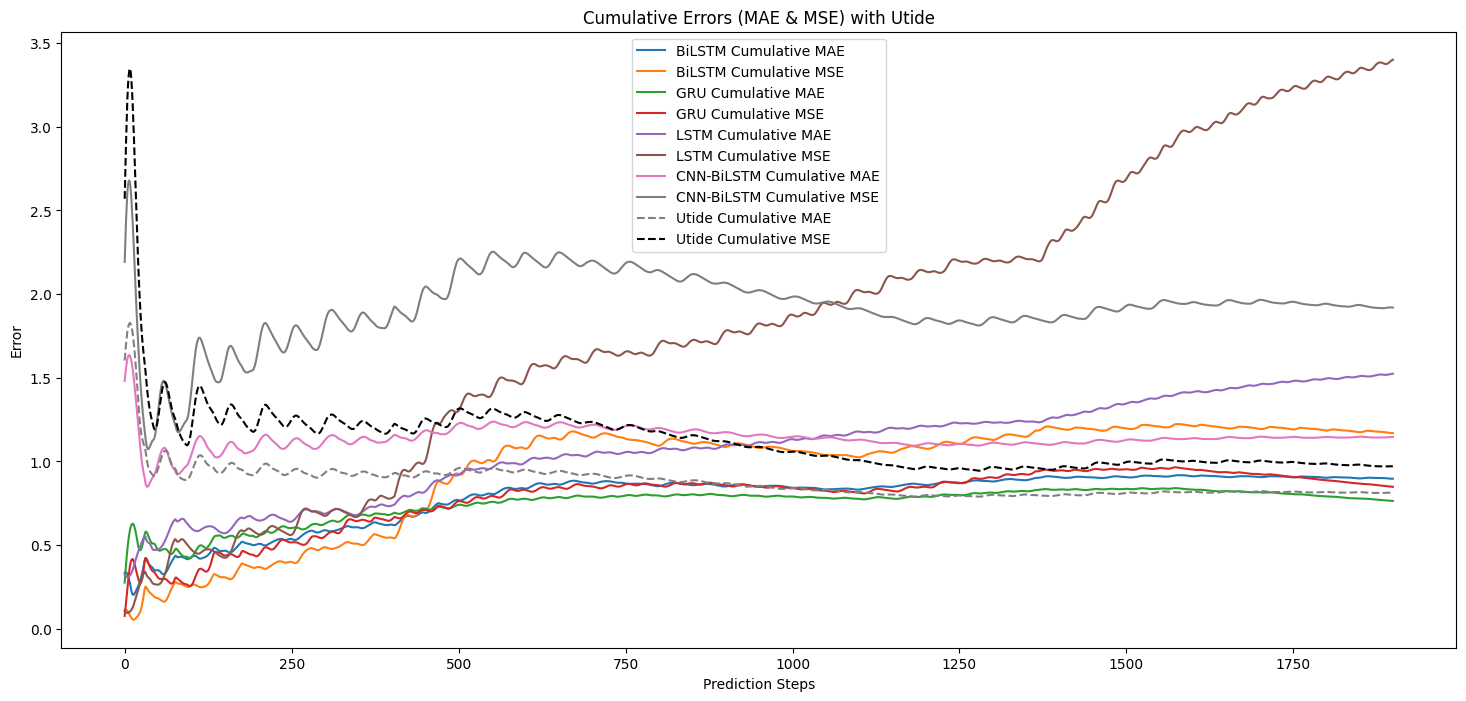

In [ ]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from keras.models import Model
from keras.layers import Dense, LSTM, GRU, Dropout, Bidirectional, Input, Conv1D
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
from sklearn.exceptions import UndefinedMetricWarning

input_file = "dataProcessed/ABE5Y1_HA_processed.csv"
df = pd.read_csv(input_file, delimiter=',')

# Set parameters
total_train_points = 10000
look_back_points = 100
total_test_points = 2000
total_required = total_train_points + look_back_points + total_test_points

max_start_index = len(df) - total_required
start_index = np.random.randint(0, max_start_index + 1)
print(f"Selected start index: {start_index}")

# Sampling data
df_sampled = df.iloc[start_index:start_index + total_required].reset_index(drop=True)
anomaly = df_sampled['anomaly'].values.reshape(-1, 1)
utide = df_sampled['utide'].values.reshape(-1, 1)

# Scale features
scaler_anomaly = MinMaxScaler(feature_range=(0, 1))
anomaly_scaled = scaler_anomaly.fit_transform(anomaly)

scaler_utide = MinMaxScaler(feature_range=(0, 1))
utide_scaled = scaler_utide.fit_transform(utide)

dataset_scaled = np.hstack((anomaly_scaled, utide_scaled))
train = dataset_scaled[:total_train_points]
test = dataset_scaled[total_train_points: total_train_points + total_test_points + look_back_points]

# Create dataset function
def create_dataset(dataset, look_back, feature_indices):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), feature_indices]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

trainX, trainY = create_dataset(train, look_back=look_back_points, feature_indices=[0])
testX, testY = create_dataset(test, look_back=look_back_points, feature_indices=[0])
num_features = trainX.shape[2]

# Model definitions
learning_rate = 0.001
weight_decay = 0.0001

# BiLSTM Model
input_layer_bilstm = Input(shape=(look_back_points, num_features))
x_bilstm = Bidirectional(LSTM(100, return_sequences=True, kernel_regularizer=l2(weight_decay)))(input_layer_bilstm)
x_bilstm = Dropout(0.3)(x_bilstm)
x_bilstm = Bidirectional(LSTM(100, kernel_regularizer=l2(weight_decay)))(x_bilstm)
output_layer_bilstm = Dense(1)(x_bilstm)
model_bilstm = Model(inputs=input_layer_bilstm, outputs=output_layer_bilstm)

# GRU Model
input_layer_gru = Input(shape=(look_back_points, num_features))
x_gru = Bidirectional(GRU(100, return_sequences=True, kernel_regularizer=l2(weight_decay)))(input_layer_gru)
x_gru = Dropout(0.3)(x_gru)
x_gru = Bidirectional(GRU(100, kernel_regularizer=l2(weight_decay)))(x_gru)
output_layer_gru = Dense(1)(x_gru)
model_gru = Model(inputs=input_layer_gru, outputs=output_layer_gru)

# LSTM Model
input_layer_lstm = Input(shape=(look_back_points, num_features))
x_lstm = LSTM(100, return_sequences=True, kernel_regularizer=l2(weight_decay))(input_layer_lstm)
x_lstm = Dropout(0.3)(x_lstm)
x_lstm = LSTM(100, kernel_regularizer=l2(weight_decay))(x_lstm)
output_layer_lstm = Dense(1)(x_lstm)
model_lstm = Model(inputs=input_layer_lstm, outputs=output_layer_lstm)

# CNN-BiLSTM Model
input_layer_cnn_bilstm = Input(shape=(look_back_points, num_features))
x_cnn_bilstm = Conv1D(filters=64, kernel_size=3, activation='relu', kernel_regularizer=l2(weight_decay))(input_layer_cnn_bilstm)
x_cnn_bilstm = Dropout(0.3)(x_cnn_bilstm)
x_cnn_bilstm = Bidirectional(LSTM(200, return_sequences=True, kernel_regularizer=l2(weight_decay)))(x_cnn_bilstm)
x_cnn_bilstm = Dropout(0.3)(x_cnn_bilstm)
x_cnn_bilstm = Bidirectional(LSTM(100, kernel_regularizer=l2(weight_decay)))(x_cnn_bilstm)
output_layer_cnn_bilstm = Dense(1)(x_cnn_bilstm)
model_cnn_bilstm = Model(inputs=input_layer_cnn_bilstm, outputs=output_layer_cnn_bilstm)

# Train models and get results
models = [model_bilstm, model_gru, model_lstm, model_cnn_bilstm]
names = ["BiLSTM", "GRU", "LSTM", "CNN-BiLSTM"]
results = {}

for model, name in zip(models, names):
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(loss='mse', optimizer=optimizer)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.7, patience=10, min_lr=1e-6, verbose=1)
    model.fit(
        trainX, trainY,
        validation_split=0.1,
        epochs=50,
        batch_size=256,
        verbose=1,
        callbacks=[reduce_lr]
    )
    results[name] = rolling_prediction(
        model=model,
        testX=testX,
        testY=testY,
        test=test,
        scaler_anomaly=scaler_anomaly,
        scaler_utide=scaler_utide,
        look_back=look_back_points,
        model_name=name
    )


# Visualization with utide values
plt.figure(figsize=(18, 10))
plt.plot(results["BiLSTM"]["actual_values"], label="Actual", color='red')
plt.plot(testY[:len(results["BiLSTM"]["actual_values"])], label="Utide", linestyle="--", color='gray')
for name, color in zip(names, ['blue', 'orange', 'purple', 'green']):
    plt.plot(results[name]['predicted_values'], label=f"{name} Predicted", linestyle="--", color=color)
plt.legend()
plt.title("Model Predictions Comparison with Utide")
plt.show()

# Update MSE and MAE comparison to include utide
def plot_mse_mae_comparison_with_utide(results, testY, steps=50):
    models = list(results.keys())
    mse_dict = {}
    mae_dict = {}
    mse_utide = []
    mae_utide = []

    for model in models:
        actual_values = results[model]["actual_values"][:steps]
        predicted_values = results[model]["predicted_values"][:steps]
        mse = (np.array(actual_values) - np.array(predicted_values)) ** 2
        mae = np.abs(np.array(actual_values) - np.array(predicted_values))
        mse_dict[model] = mse
        mae_dict[model] = mae

    # Calculate Utide MSE and MAE
    utide_actual = results["BiLSTM"]["actual_values"][:steps]
    utide_mse = (np.array(utide_actual) - testY[:steps]) ** 2
    utide_mae = np.abs(np.array(utide_actual) - testY[:steps])
    mse_utide = utide_mse
    mae_utide = utide_mae

    # MSE
    x = np.arange(steps)
    width = 0.2
    plt.figure(figsize=(18, 8))
    for idx, model in enumerate(models):
        plt.bar(x + idx * width - width * len(models) / 2, mse_dict[model], width, label=f"{model} MSE")
    plt.bar(x + len(models) * width - width * len(models) / 2, mse_utide, width, label="Utide MSE", color='gray')
    plt.title("Comparison of MSE for First 200 Steps with Utide")
    plt.xlabel("Prediction Steps")
    plt.ylabel("MSE")
    plt.legend()
    plt.show()

    #  MAE
    plt.figure(figsize=(18, 8))
    for idx, model in enumerate(models):
        plt.bar(x + idx * width - width * len(models) / 2, mae_dict[model], width, label=f"{model} MAE")
    plt.bar(x + len(models) * width - width * len(models) / 2, mae_utide, width, label="Utide MAE", color='gray')
    plt.title("Comparison of MAE for First 200 Steps with Utide")
    plt.xlabel("Prediction Steps")
    plt.ylabel("MAE")
    plt.legend()
    plt.show()

# updated comparison function
plot_mse_mae_comparison_with_utide(results, testY, steps=50)

# Update cumulative errors to include Utide
def plot_cumulative_errors_with_utide(results, testY, start_index=0):
    models = list(results.keys())
    plt.figure(figsize=(18, 8))

    for model in models:
        actual_values = results[model]["actual_values"][start_index:]
        predicted_values = results[model]["predicted_values"][start_index:]
        cumulative_mae = np.cumsum(np.abs(np.array(actual_values) - np.array(predicted_values))) / np.arange(1, len(actual_values) + 1)
        cumulative_mse = np.cumsum((np.array(actual_values) - np.array(predicted_values)) ** 2) / np.arange(1, len(actual_values) + 1)

        plt.plot(cumulative_mae, label=f"{model} Cumulative MAE")
        plt.plot(cumulative_mse, label=f"{model} Cumulative MSE")

    # Utide cumulative errors
    utide_actual = results["BiLSTM"]["actual_values"][start_index:]
    cumulative_mae_utide = np.cumsum(np.abs(np.array(utide_actual) - testY[start_index:])) / np.arange(1, len(utide_actual) + 1)
    cumulative_mse_utide = np.cumsum((np.array(utide_actual) - testY[start_index:]) ** 2) / np.arange(1, len(utide_actual) + 1)

    plt.plot(cumulative_mae_utide, label="Utide Cumulative MAE", linestyle="--", color='gray')
    plt.plot(cumulative_mse_utide, label="Utide Cumulative MSE", linestyle="--", color='black')

    plt.title("Cumulative Errors (MAE & MSE) with Utide")
    plt.xlabel("Prediction Steps")
    plt.ylabel("Error")
    plt.legend()
    plt.show()

plot_cumulative_errors_with_utide(results, testY, start_index=look_back_points)

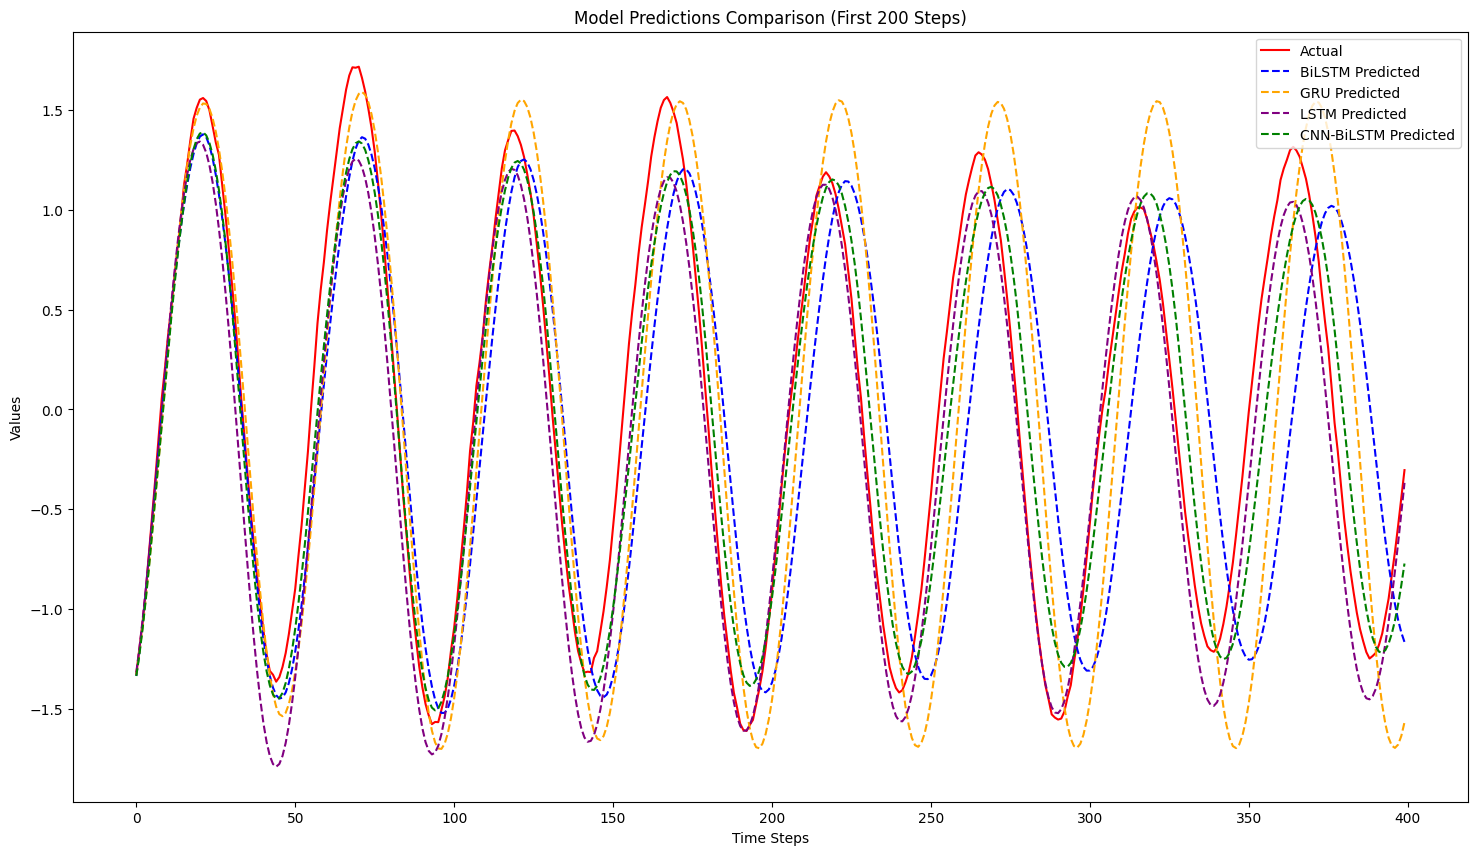

In [ ]:
plt.figure(figsize=(18, 10))
plt.plot(results["BiLSTM"]["actual_values"][:400], label="Actual", color='red')  # 仅绘制前200个实际值
for name, color in zip(names, ['blue', 'orange', 'purple', 'green']):
    plt.plot(results[name]['predicted_values'][:400], label=f"{name} Predicted", linestyle="--", color=color)  # 仅绘制前200个预测值
plt.legend()
plt.title("Model Predictions Comparison (First 200 Steps)")
plt.xlabel("Time Steps")
plt.ylabel("Values")
plt.show()

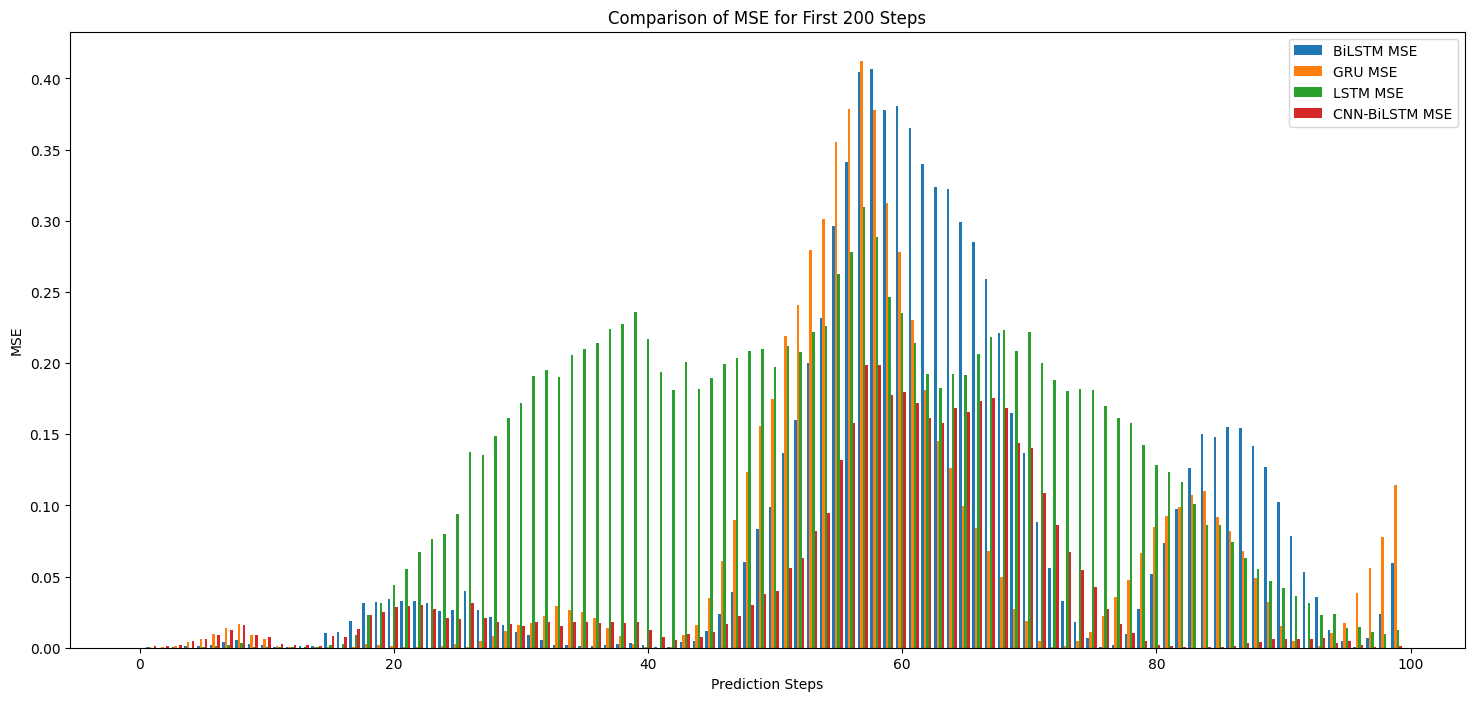

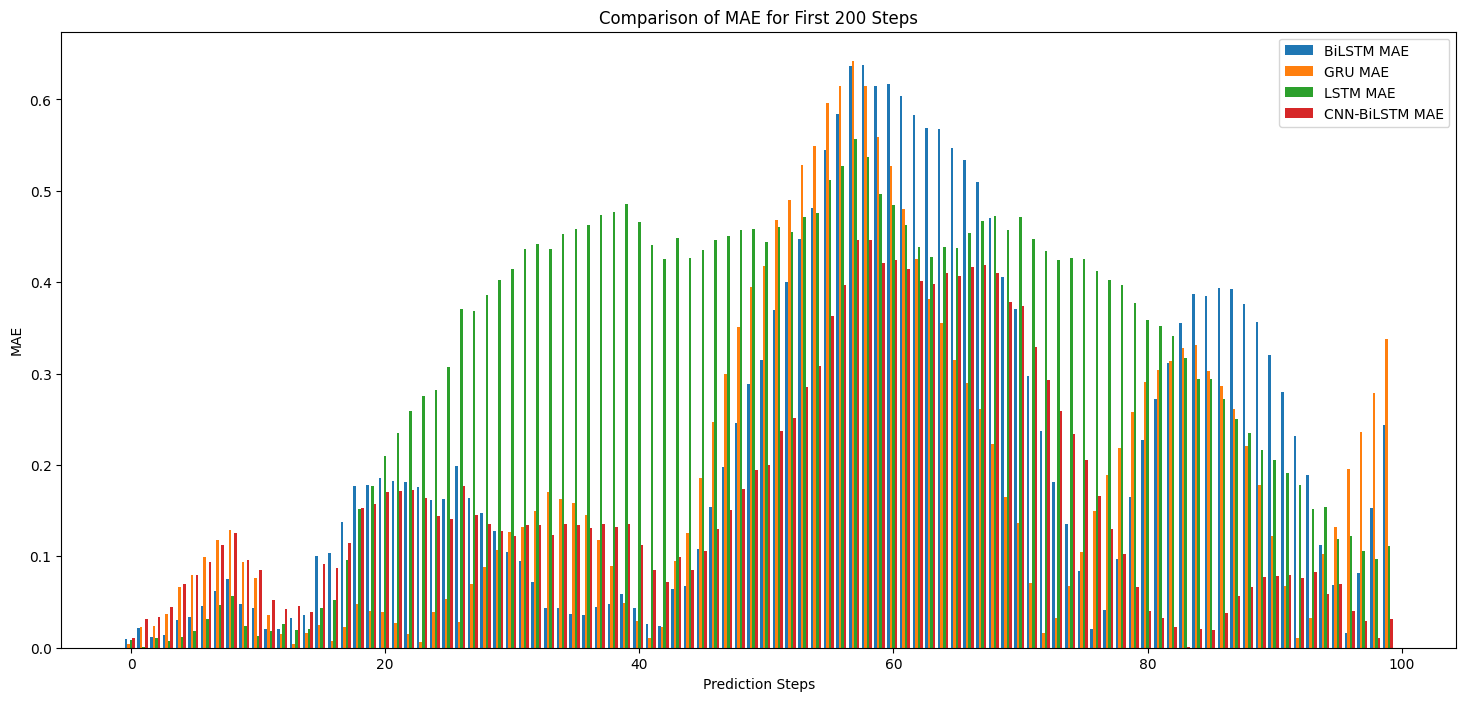

In [ ]:
def plot_mse_mae_comparison(results, steps=100):
    models = list(results.keys())
    mse_dict = {}
    mae_dict = {}

    for model in models:
        actual_values = results[model]["actual_values"][:steps]
        predicted_values = results[model]["predicted_values"][:steps]
        mse = (np.array(actual_values) - np.array(predicted_values)) ** 2
        mae = np.abs(np.array(actual_values) - np.array(predicted_values))
        mse_dict[model] = mse
        mae_dict[model] = mae

    x = np.arange(steps)
    width = 0.2
    plt.figure(figsize=(18, 8))
    for idx, model in enumerate(models):
        plt.bar(x + idx * width - width * len(models) / 2, mse_dict[model], width, label=f"{model} MSE")
    plt.title("Comparison of MSE for First 200 Steps")
    plt.xlabel("Prediction Steps")
    plt.ylabel("MSE")
    plt.legend()
    plt.show()

    plt.figure(figsize=(18, 8))
    for idx, model in enumerate(models):
        plt.bar(x + idx * width - width * len(models) / 2, mae_dict[model], width, label=f"{model} MAE")
    plt.title("Comparison of MAE for First 200 Steps")
    plt.xlabel("Prediction Steps")
    plt.ylabel("MAE")
    plt.legend()
    plt.show()
plot_mse_mae_comparison(results, steps=100)

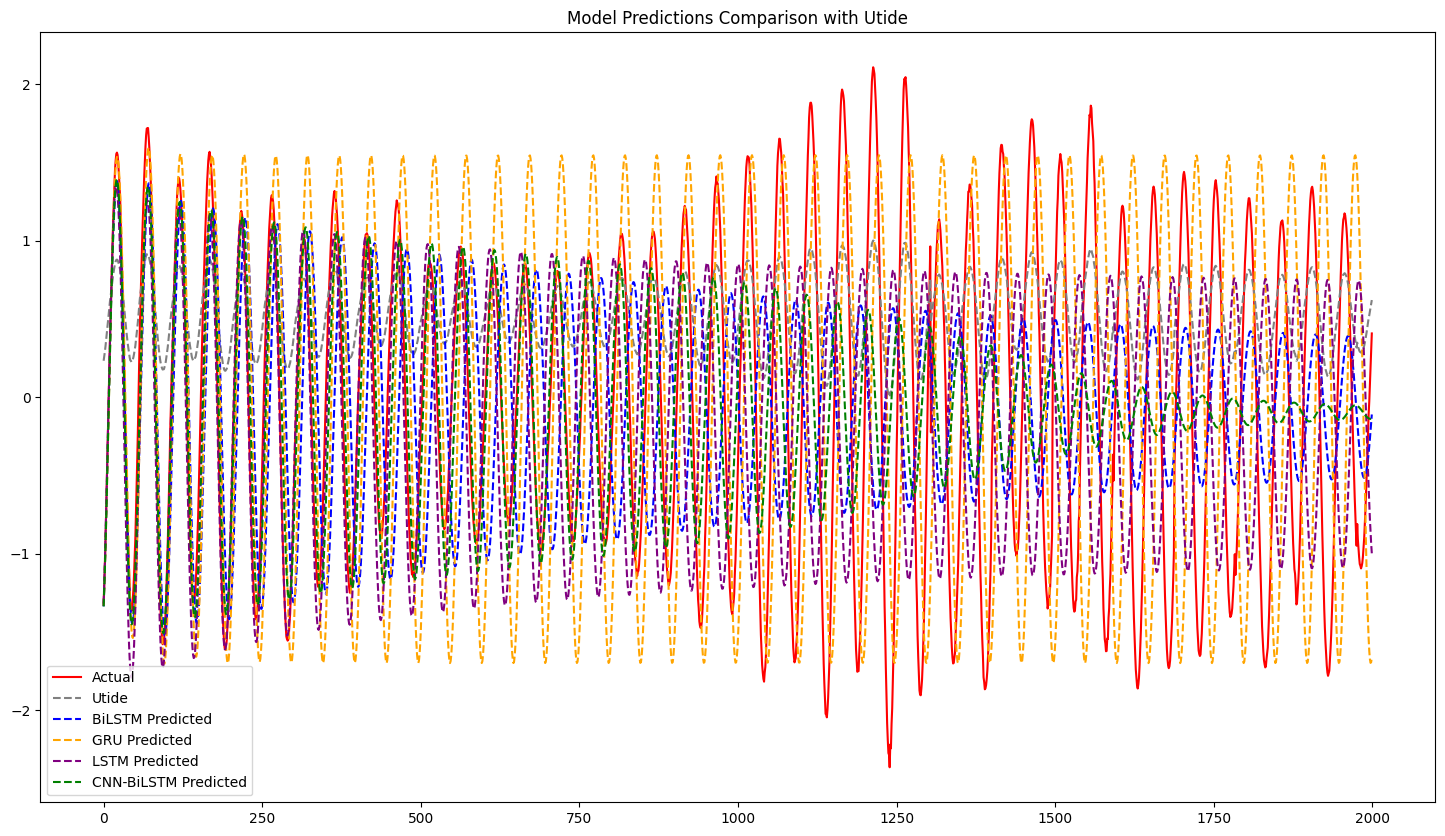

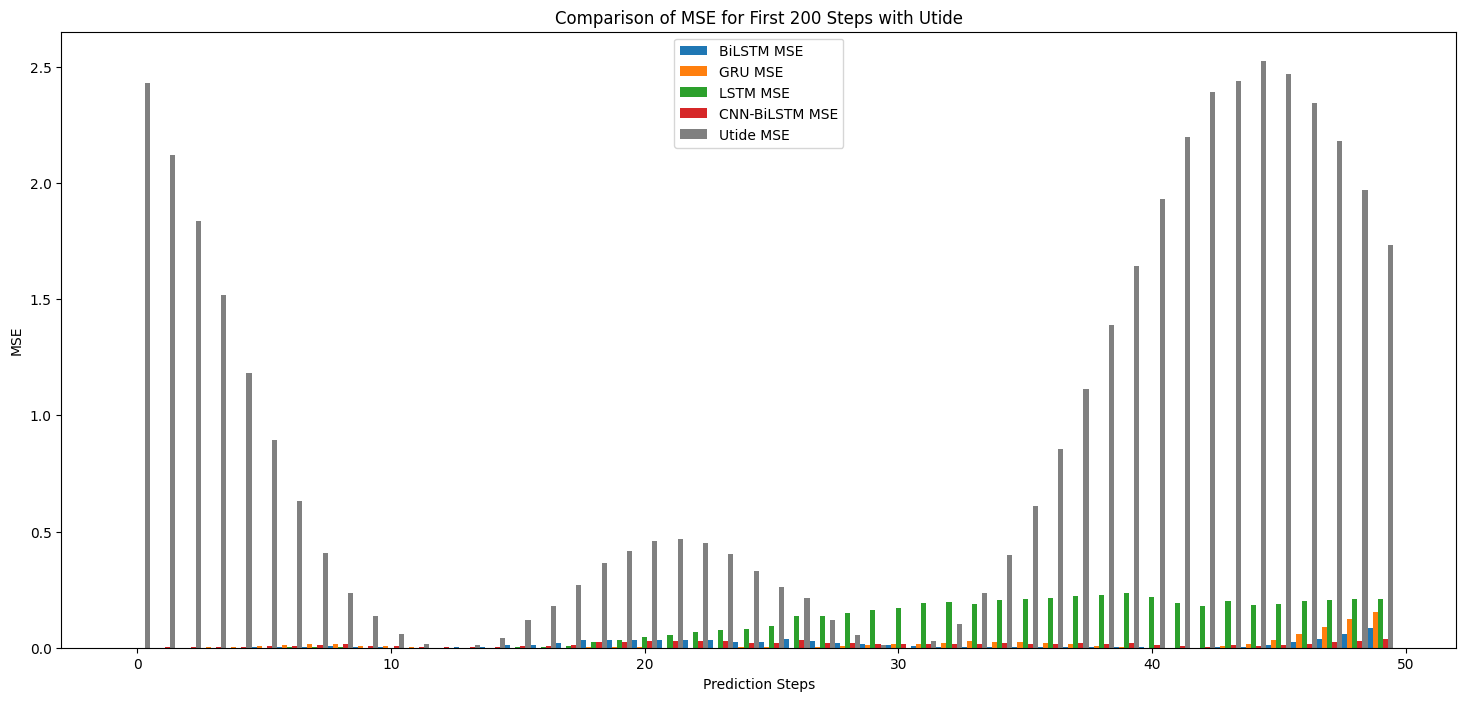

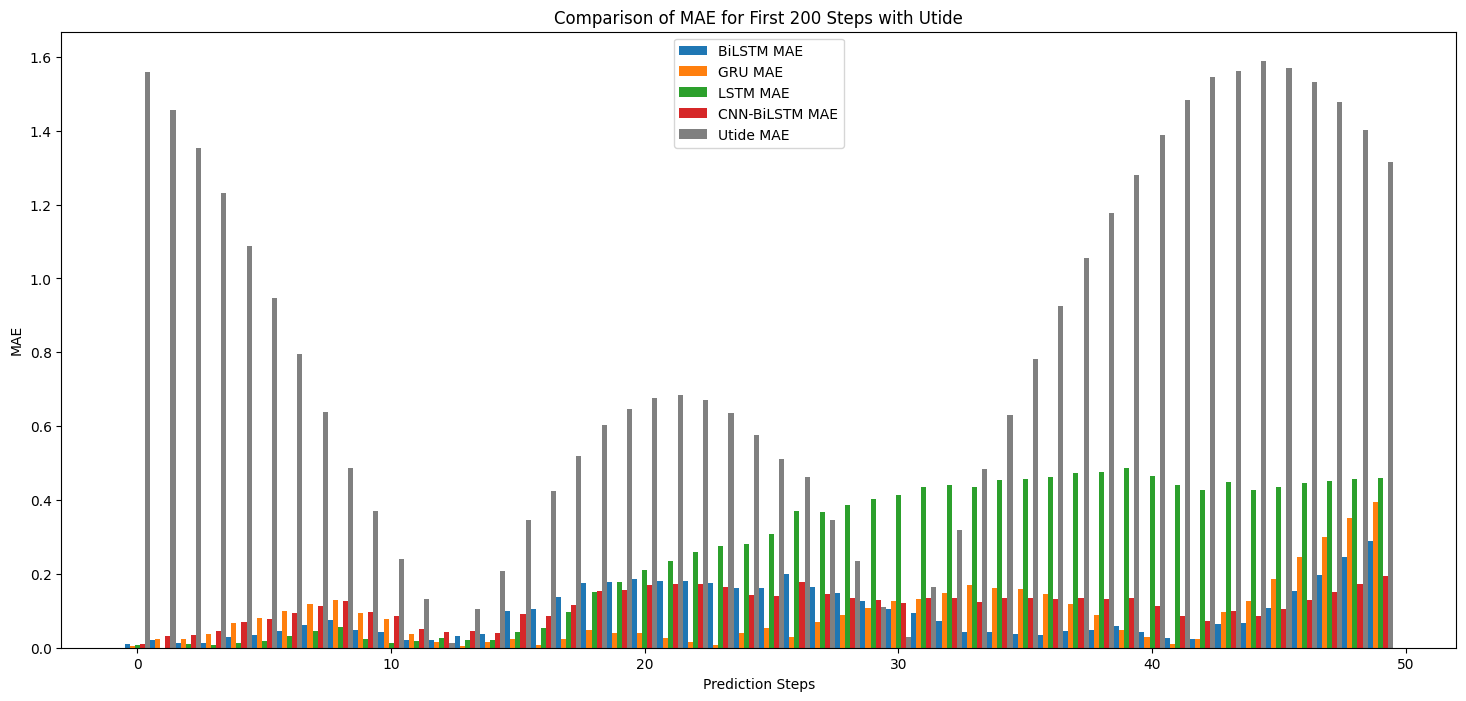

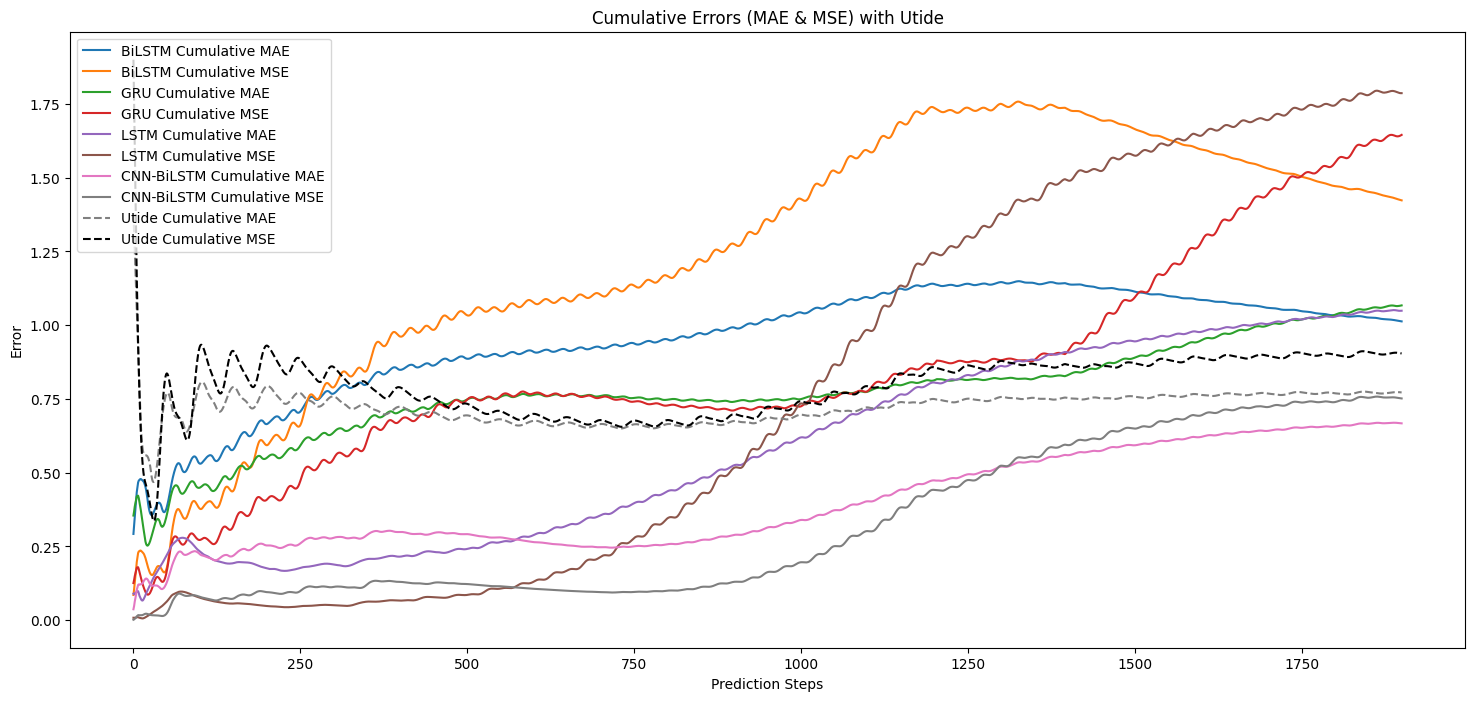

In [ ]:
# Visualization with utide values
plt.figure(figsize=(18, 10))
plt.plot(results["BiLSTM"]["actual_values"], label="Actual", color='red')
plt.plot(testY[:len(results["BiLSTM"]["actual_values"])], label="Utide", linestyle="--", color='gray')
for name, color in zip(names, ['blue', 'orange', 'purple', 'green']):
    plt.plot(results[name]['predicted_values'], label=f"{name} Predicted", linestyle="--", color=color)
plt.legend()
plt.title("Model Predictions Comparison with Utide")
plt.show()

# Update MSE and MAE comparison to include utide
def plot_mse_mae_comparison_with_utide(results, testY, steps=50):
    models = list(results.keys())
    mse_dict = {}
    mae_dict = {}
    mse_utide = []
    mae_utide = []

    for model in models:
        actual_values = results[model]["actual_values"][:steps]
        predicted_values = results[model]["predicted_values"][:steps]
        mse = (np.array(actual_values) - np.array(predicted_values)) ** 2
        mae = np.abs(np.array(actual_values) - np.array(predicted_values))
        mse_dict[model] = mse
        mae_dict[model] = mae

    # Calculate Utide MSE and MAE
    utide_actual = results["BiLSTM"]["actual_values"][:steps]
    utide_mse = (np.array(utide_actual) - testY[:steps]) ** 2
    utide_mae = np.abs(np.array(utide_actual) - testY[:steps])
    mse_utide = utide_mse
    mae_utide = utide_mae

    # MSE
    x = np.arange(steps)
    width = 0.2
    plt.figure(figsize=(18, 8))
    for idx, model in enumerate(models):
        plt.bar(x + idx * width - width * len(models) / 2, mse_dict[model], width, label=f"{model} MSE")
    plt.bar(x + len(models) * width - width * len(models) / 2, mse_utide, width, label="Utide MSE", color='gray')
    plt.title("Comparison of MSE for First 200 Steps with Utide")
    plt.xlabel("Prediction Steps")
    plt.ylabel("MSE")
    plt.legend()
    plt.show()

    # MAE
    plt.figure(figsize=(18, 8))
    for idx, model in enumerate(models):
        plt.bar(x + idx * width - width * len(models) / 2, mae_dict[model], width, label=f"{model} MAE")
    plt.bar(x + len(models) * width - width * len(models) / 2, mae_utide, width, label="Utide MAE", color='gray')
    plt.title("Comparison of MAE for First 200 Steps with Utide")
    plt.xlabel("Prediction Steps")
    plt.ylabel("MAE")
    plt.legend()
    plt.show()

# updated comparison function
plot_mse_mae_comparison_with_utide(results, testY, steps=50)

# Update cumulative errors to include Utide
def plot_cumulative_errors_with_utide(results, testY, start_index=0):
    models = list(results.keys())
    plt.figure(figsize=(18, 8))

    for model in models:
        actual_values = results[model]["actual_values"][start_index:]
        predicted_values = results[model]["predicted_values"][start_index:]
        cumulative_mae = np.cumsum(np.abs(np.array(actual_values) - np.array(predicted_values))) / np.arange(1, len(actual_values) + 1)
        cumulative_mse = np.cumsum((np.array(actual_values) - np.array(predicted_values)) ** 2) / np.arange(1, len(actual_values) + 1)

        plt.plot(cumulative_mae, label=f"{model} Cumulative MAE")
        plt.plot(cumulative_mse, label=f"{model} Cumulative MSE")

    # Utide cumulative errors
    utide_actual = results["BiLSTM"]["actual_values"][start_index:]
    cumulative_mae_utide = np.cumsum(np.abs(np.array(utide_actual) - testY[start_index:])) / np.arange(1, len(utide_actual) + 1)
    cumulative_mse_utide = np.cumsum((np.array(utide_actual) - testY[start_index:]) ** 2) / np.arange(1, len(utide_actual) + 1)

    plt.plot(cumulative_mae_utide, label="Utide Cumulative MAE", linestyle="--", color='gray')
    plt.plot(cumulative_mse_utide, label="Utide Cumulative MSE", linestyle="--", color='black')

    plt.title("Cumulative Errors (MAE & MSE) with Utide")
    plt.xlabel("Prediction Steps")
    plt.ylabel("Error")
    plt.legend()
    plt.show()

plot_cumulative_errors_with_utide(results, testY, start_index=look_back_points)

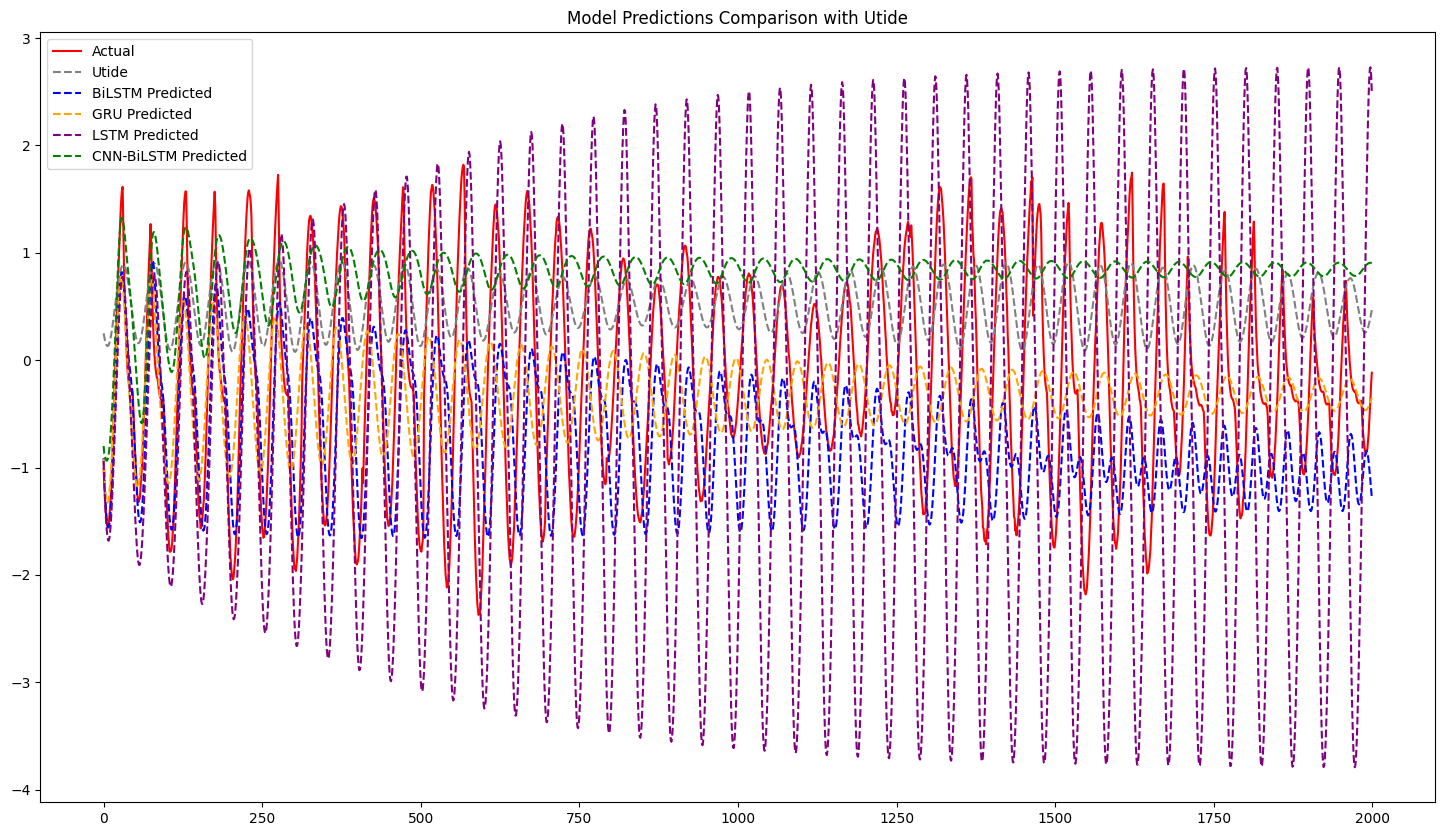

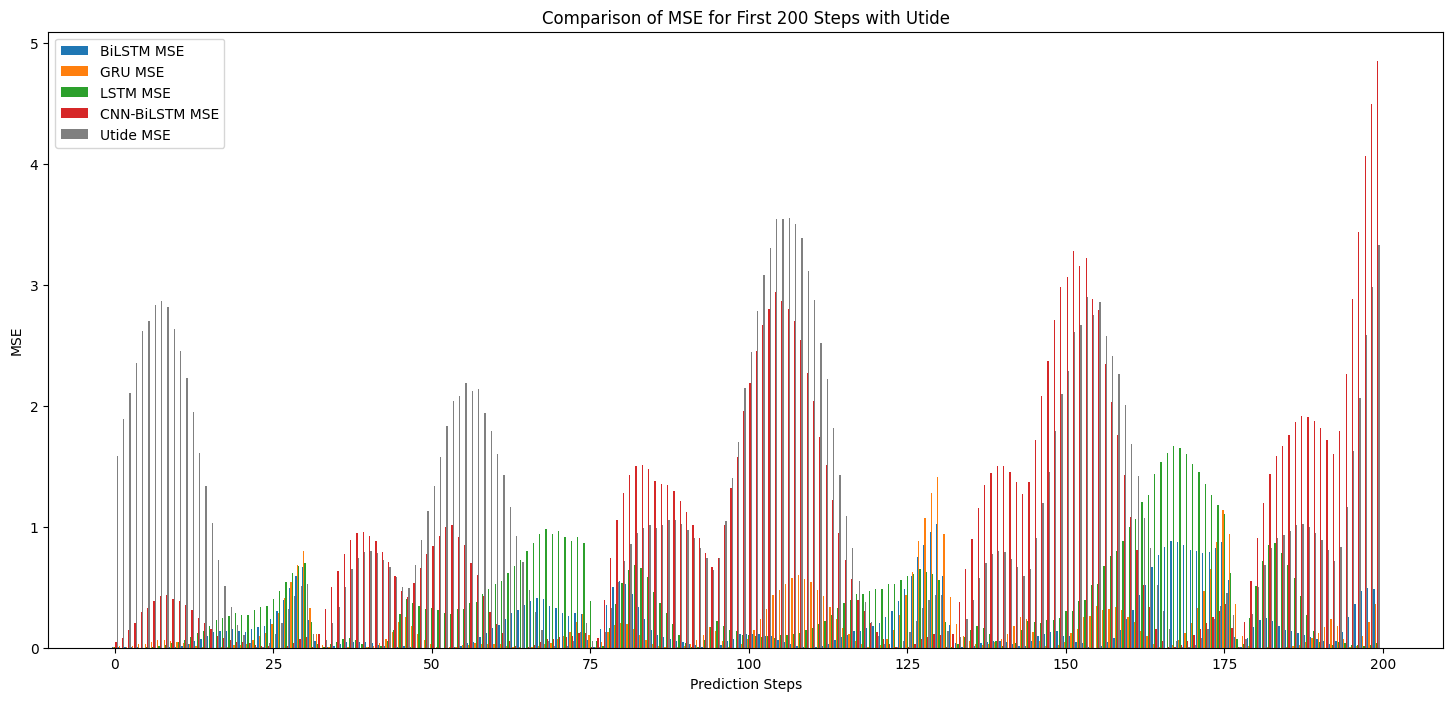

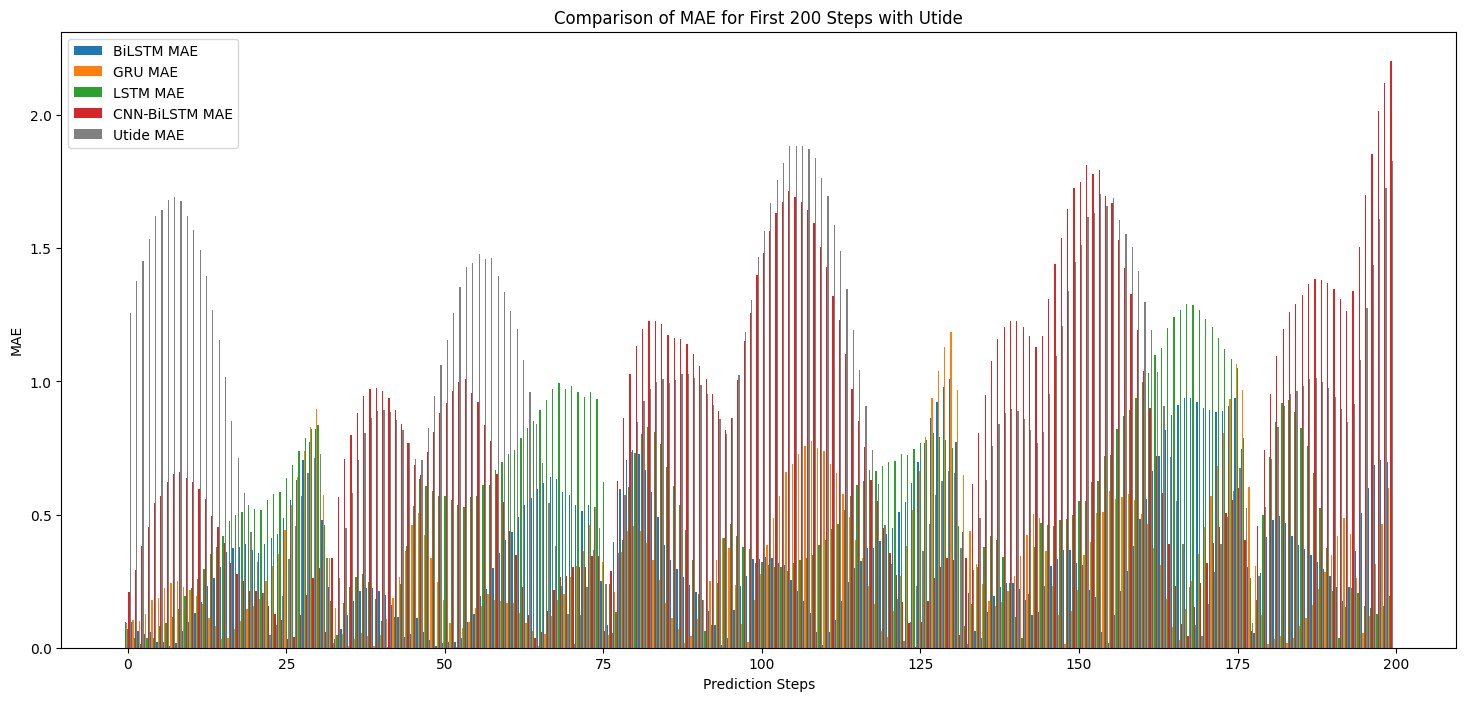

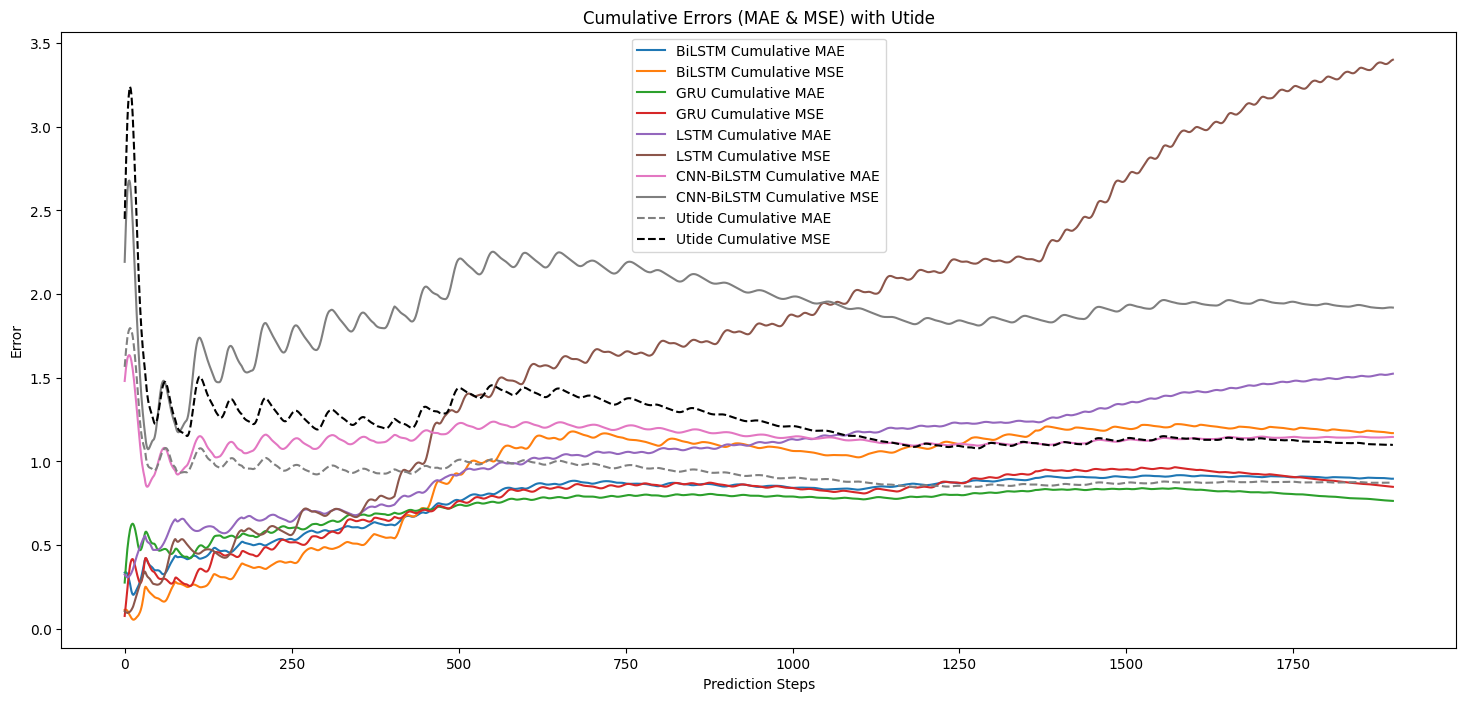

In [ ]:
plt.figure(figsize=(18, 10))
plt.plot(results["BiLSTM"]["actual_values"], label="Actual", color='red')
plt.plot(test[look_back_points:, 1], label="Utide", linestyle="--", color='gray')
for name, color in zip(names, ['blue', 'orange', 'purple', 'green']):
    plt.plot(results[name]['predicted_values'], label=f"{name} Predicted", linestyle="--", color=color)
plt.legend()
plt.title("Model Predictions Comparison with Utide")
plt.show()

#update
def plot_mse_mae_comparison_with_utide(results, test, steps=200):
    models = list(results.keys())
    mse_dict = {}
    mae_dict = {}
    mse_utide = []
    mae_utide = []

    for model in models:
        actual_values = results[model]["actual_values"][:steps]
        predicted_values = results[model]["predicted_values"][:steps]
        mse = (np.array(actual_values) - np.array(predicted_values)) ** 2
        mae = np.abs(np.array(actual_values) - np.array(predicted_values))
        mse_dict[model] = mse
        mae_dict[model] = mae

    utide_actual = results["BiLSTM"]["actual_values"][:steps]
    utide_values = test[look_back_points:look_back_points + steps, 1]
    utide_mse = (np.array(utide_actual) - utide_values) ** 2
    utide_mae = np.abs(np.array(utide_actual) - utide_values)
    mse_utide = utide_mse
    mae_utide = utide_mae
    #histgram
    x = np.arange(steps)
    width = 0.2
    plt.figure(figsize=(18, 8))
    for idx, model in enumerate(models):
        plt.bar(x + idx * width - width * len(models) / 2, mse_dict[model], width, label=f"{model} MSE")
    plt.bar(x + len(models) * width - width * len(models) / 2, mse_utide, width, label="Utide MSE", color='gray')
    plt.title("Comparison of MSE for First 200 Steps with Utide")
    plt.xlabel("Prediction Steps")
    plt.ylabel("MSE")
    plt.legend()
    plt.show()

    plt.figure(figsize=(18, 8))
    for idx, model in enumerate(models):
        plt.bar(x + idx * width - width * len(models) / 2, mae_dict[model], width, label=f"{model} MAE")
    plt.bar(x + len(models) * width - width * len(models) / 2, mae_utide, width, label="Utide MAE", color='gray')
    plt.title("Comparison of MAE for First 200 Steps with Utide")
    plt.xlabel("Prediction Steps")
    plt.ylabel("MAE")
    plt.legend()
    plt.show()

plot_mse_mae_comparison_with_utide(results, test, steps=200)

def plot_cumulative_errors_with_utide(results, test, start_index=0):
    models = list(results.keys())
    plt.figure(figsize=(18, 8))

    for model in models:
        actual_values = results[model]["actual_values"][start_index:]
        predicted_values = results[model]["predicted_values"][start_index:]
        cumulative_mae = np.cumsum(np.abs(np.array(actual_values) - np.array(predicted_values))) / np.arange(1, len(actual_values) + 1)
        cumulative_mse = np.cumsum((np.array(actual_values) - np.array(predicted_values)) ** 2) / np.arange(1, len(actual_values) + 1)

        plt.plot(cumulative_mae, label=f"{model} Cumulative MAE")
        plt.plot(cumulative_mse, label=f"{model} Cumulative MSE")

    utide_actual = results["BiLSTM"]["actual_values"][start_index:]
    utide_values = test[look_back_points + start_index:, 1]
    cumulative_mae_utide = np.cumsum(np.abs(np.array(utide_actual) - utide_values)) / np.arange(1, len(utide_actual) + 1)
    cumulative_mse_utide = np.cumsum((np.array(utide_actual) - utide_values) ** 2) / np.arange(1, len(utide_actual) + 1)

    plt.plot(cumulative_mae_utide, label="Utide Cumulative MAE", linestyle="--", color='gray')
    plt.plot(cumulative_mse_utide, label="Utide Cumulative MSE", linestyle="--", color='black')

    plt.title("Cumulative Errors (MAE & MSE) with Utide")
    plt.xlabel("Prediction Steps")
    plt.ylabel("Error")
    plt.legend()
    plt.show()

plot_cumulative_errors_with_utide(results, test, start_index=look_back_points)